<a href="https://colab.research.google.com/github/SimoSnoussi/Deep-UpwellRes-Net-a-convolutional-neural-network-for-Upwelling-detection-/blob/master/All_In_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

from keras import backend as K 
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, Reshape, Conv2DTranspose, Add
from keras.layers import BatchNormalization, Activation 
from keras.models import Model, load_model 
from keras.optimizers import Adam 
from IPython.display import SVG 
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau 
from keras.utils import np_utils, plot_model



Using TensorFlow backend.


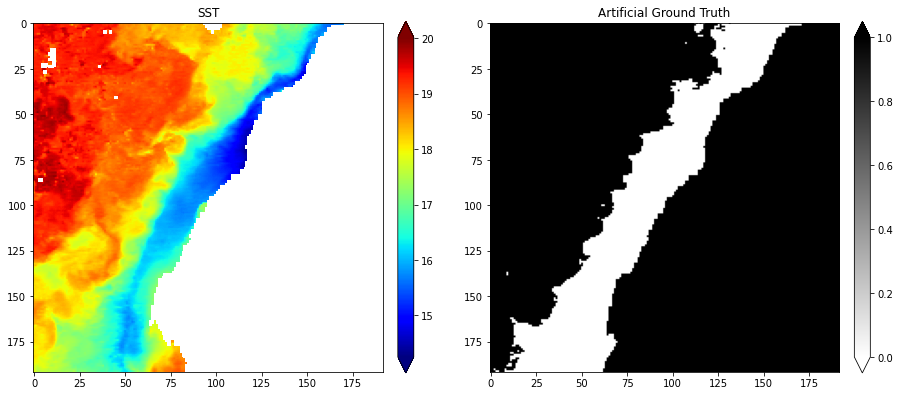

In [10]:
sst_path  = '/SST_train.npy'
mask_path = '/MASK_train.npy'

sst_train  = np.load(sst_path)
mask_train = np.load(mask_path)
mask_train = np.nan_to_num(mask_train, nan=1)

index = np.random.randint(sst_train.shape[0])

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(sst_train[index,:,:], cmap='jet')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.title('SST');
plt.subplot(122)
plt.imshow(mask_train[index,:,:], cmap='binary')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.title('Artificial Ground Truth');

In [ ]:
sst_train = np.nan_to_num(sst_train, nan=1)

### Expand dims 
sst_train = np.expand_dims(sst_train, 3)
mask_train = np.expand_dims(mask_train, 3)

### One-Hot-Encoding 
mask_train_cat = np.reshape(mask_train[:,:,:,0], (1374,192*192))
mask_train_cat = np_utils.to_categorical(mask_train_cat, 2)
print(mask_train_cat.shape)

(1374, 36864, 2)


In [ ]:
def BatchActivation(x): 
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x 

def convBlock(x, filters, size, padding='same', activation=True): 
  x = Conv2D(filters, size, padding=padding)(x)
  if activation == True: 
    x = BatchActivation(x)
  return x 

def residualBlock(blockInput, num_filters=16, batch_activation=False): 
  x = BatchActivation(blockInput)
  x = convBlock(x, num_filters, (3,3))
  x = convBlock(x, num_filters, (3,3), activation=False)
  x = Add()([x, blockInput])
  if batch_activation: 
    x = BatchActivation(x)
  return x 

In [ ]:
input_size  = (192, 192, 1) 

def get_resunet(input_img, n_filters, DropoutRatio = 0.5, num_classes=2):
    # contracting path
    c1 = Conv2D(n_filters * 1, (3, 3), activation=None, padding="same")(input_img)
    c1 = residualBlock(c1, n_filters * 1)
    c1 = residualBlock(c1, n_filters * 1, True)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(DropoutRatio/2)(p1)

    c2 = Conv2D(n_filters * 2, (3, 3), activation=None, padding="same")(p1)
    c2 = residualBlock(c2, n_filters * 2)
    c2 = residualBlock(c2, n_filters * 2, True)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(DropoutRatio)(p2)

    c3 = Conv2D(n_filters * 4, (3, 3), activation=None, padding="same")(p2)
    c3 = residualBlock(c3, n_filters * 4)
    c3 = residualBlock(c3, n_filters * 4, True)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(DropoutRatio)(p3)

    c4 = Conv2D(n_filters * 8, (3, 3), activation=None, padding="same")(p3)
    c4 = residualBlock(c4, n_filters * 8)
    c4 = residualBlock(c4, n_filters * 8, True)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(DropoutRatio)(p4)
 
    # Bottleneck 
    c5 = Conv2D(n_filters * 16, (3, 3), activation=None, padding="same")(p4)
    c5 = residualBlock(c5,n_filters * 16)
    c5 = residualBlock(c5,n_filters * 16, True)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(DropoutRatio)(u6)
    c6 = Conv2D(n_filters * 8, (3, 3), activation=None, padding="same")(u6)
    c6 = residualBlock(c6,n_filters * 8)
    c6 = residualBlock(c6,n_filters * 8, True)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(DropoutRatio)(u7)
    c7 = Conv2D(n_filters * 4, (3, 3), activation=None, padding="same")(u7)
    c7 = residualBlock(c7,n_filters * 4)
    c7 = residualBlock(c7,n_filters * 4, True)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(DropoutRatio)(u8)
    c8 = Conv2D(n_filters * 2, (3, 3), activation=None, padding="same")(u8)
    c8 = residualBlock(c8,n_filters * 2)
    c8 = residualBlock(c8,n_filters * 2, True)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(DropoutRatio)(u9)
    c9 = Conv2D(n_filters * 1, (3, 3), activation=None, padding="same")(u9)
    c9 = residualBlock(c9,n_filters * 1)
    c9 = residualBlock(c9,n_filters * 1, True)
 
    output     = Conv2D(num_classes, (1,1), padding='valid')(c9)
    output     = Reshape((input_size[0]*input_size[1], num_classes))(output)
    output     = Activation('softmax')(output)
    model = Model(inputs=[input_img], outputs=[output])
    return model

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [ ]:
input_size  = (192, 192, 1) 
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True, num_classes=2):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    # Bottleneck 
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    output     = Conv2D(num_classes, (1,1), padding='valid')(c9)
    output     = Reshape((input_size[0]*input_size[1], num_classes))(output)
    output     = Activation('softmax')(output)
    model = Model(inputs=[input_img], outputs=[output])
    return model

# Calculate Weigths (Data Imbalance)

In [ ]:
unique, counts = np.unique(mask_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 8085897, 1.0: 42565239}

In [ ]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[0.8403609940752366, 0.15963900592476346]

In [ ]:
epsilon=0.00001  ## small constant add to numerator and denominator to avoid division by zero errors. 

### IoU coefficient 
def iou_class_1(y_true, y_pred):
  y_true_ = y_true[:,:,0]
  y_pred_ = y_pred[:,:,0]
  intersection = K.sum(y_true_ * y_pred_)
  union = (K.sum(y_true_) + K.sum(y_pred_)) - intersection
  iou = (intersection + epsilon) / (union + epsilon)
  return iou

def iou_class_2(y_true, y_pred):
  y_true_ = y_true[:,:,1]
  y_pred_ = y_pred[:,:,1]
  intersection = K.sum(y_true_ * y_pred_)
  union = (K.sum(y_true_) + K.sum(y_pred_)) - intersection
  iou = (intersection + epsilon) / (union + epsilon)
  return iou

def mean_iou(y_true, y_pred): 
  return ((iou_class_1(y_true, y_pred) + iou_class_2(y_true, y_pred)) / 2)


### Dice Coefficient 
def dice_coef_class_1(y_true, y_pred): 
  y_true_ = y_true[:,:,0]
  y_pred_ = y_pred[:,:,0]
  dice_numerator   = 2 * K.sum(y_true_ * y_pred_) + epsilon 
  dice_denominator = K.sum(y_true_) + K.sum(y_pred_) + epsilon 
  dice_coeff       = dice_numerator / dice_denominator 
  return dice_coeff 

def dice_coef_class_2(y_true, y_pred): 
  y_true_ = y_true[:,:,1]
  y_pred_ = y_pred[:,:,1]
  dice_numerator   = 2 * K.sum(y_true_ * y_pred_) + epsilon 
  dice_denominator = K.sum(y_true_) + K.sum(y_pred_) + epsilon 
  dice_coeff       = dice_numerator / dice_denominator
  return dice_coeff 

def dice_coefficient(y_true, y_pred): 
  return ((dice_coef_class_1(y_true, y_pred) + dice_coef_class_2(y_true, y_pred)) / 2) 

### Weighted Dice Loss 
def weighted_dice_coef(y_true, y_pred):
    return (0.84*dice_coef_class_1(y_true, y_pred) + 0.16*dice_coef_class_2(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_dice_coef(y_true, y_pred)

In [ ]:
### UpwellRes-Net 
input_img = Input(input_size)
upwellres = get_resunet(input_img, n_filters=16, DropoutRatio = 0.5, num_classes=2)

upwellres.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=["categorical_accuracy", dice_coefficient, 
                                                              dice_coef_class_1, dice_coef_class_2, mean_iou])
upwellres.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 192, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 192, 192, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
### UpwellNet
input_img = Input(input_size)
upwellnet = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)

upwellnet.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=["categorical_accuracy", dice_coefficient, 
                                                              dice_coef_class_1, dice_coef_class_2, mean_iou])
upwellnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 192, 192, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 192, 192, 16) 64          conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 192, 192, 16) 0           batch_normalization_46[0][0]     
____________________________________________________________________________________________

In [ ]:
upwellres.load_weights('/model-ResUpwellNet-0.h5')
upwellnet.load_weights('/model-UupwellNet-0.h5')

In [ ]:
# randindex=np.random.randint(0,len(sst_train))
randindex=1320


### Prediction using UpwellRes-Net
predictedSEGM_Res=upwellres.predict(np.reshape(sst_train[randindex,:,:],(1,input_size[0],input_size[1],1)))
predictedSEGMimage_Res = np.reshape(predictedSEGM_Res.argmax(2),(input_size[0],input_size[1]))

### Prediction using Upwell-Net
predictedSEGM_Net=upwellnet.predict(np.reshape(sst_train[randindex,:,:],(1,input_size[0],input_size[1],1)))
predictedSEGMimage_Net = np.reshape(predictedSEGM_Net.argmax(2),(input_size[0],input_size[1]))

In [ ]:
# randindex_1=np.random.randint(0,len(sst_train))
randindex_1=1333

### Prediction using UpwellRes-Net
predictedSEGM_Res_1=upwellres.predict(np.reshape(sst_train[randindex_1,:,:],(1,input_size[0],input_size[1],1)))
predictedSEGMimage_Res_1 = np.reshape(predictedSEGM_Res_1.argmax(2),(input_size[0],input_size[1]))

### Prediction using Upwell-Net
predictedSEGM_Net_1=upwellnet.predict(np.reshape(sst_train[randindex_1,:,:],(1,input_size[0],input_size[1],1)))
predictedSEGMimage_Net_1 = np.reshape(predictedSEGM_Net_1.argmax(2),(input_size[0],input_size[1]))

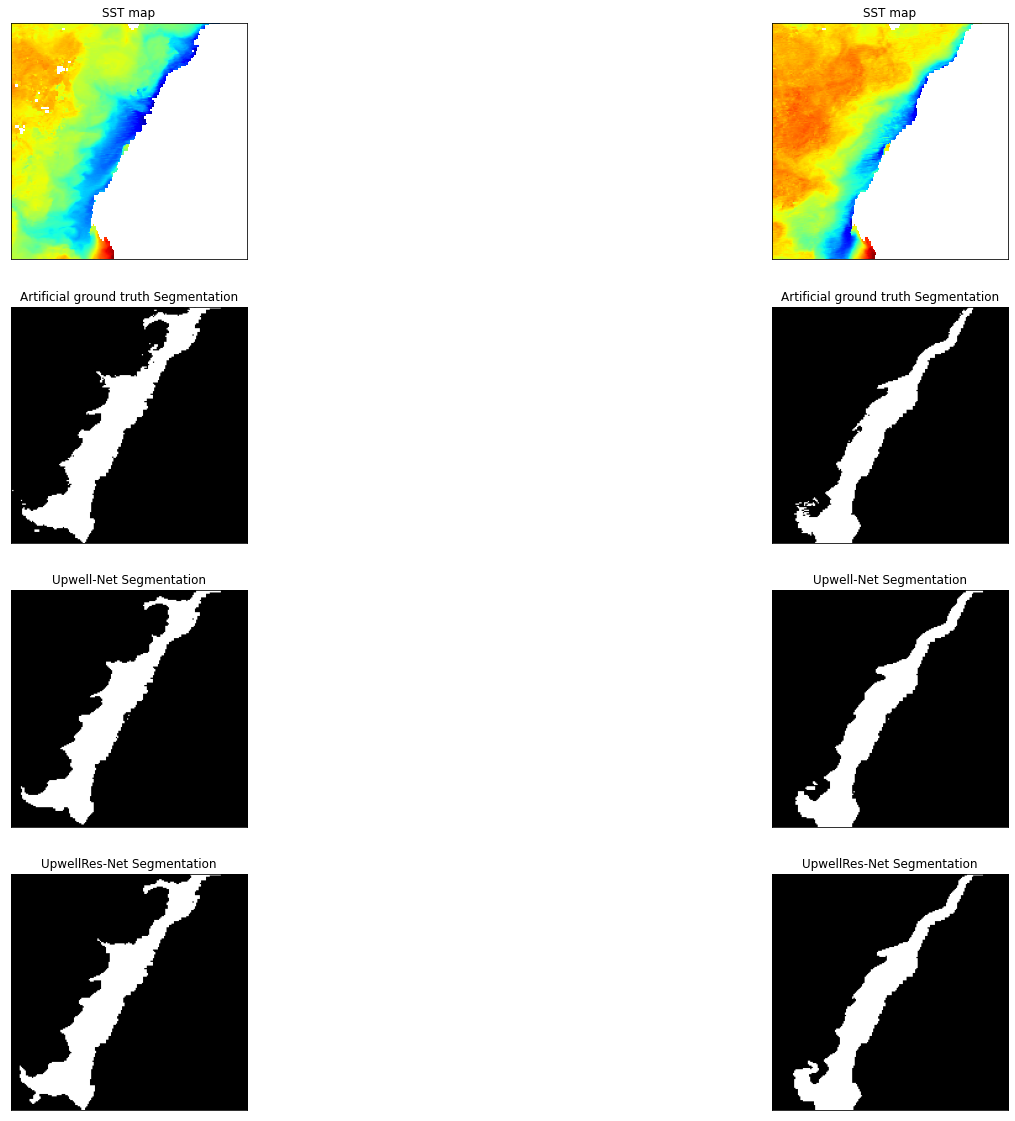

In [ ]:
plt.figure(figsize=(25, 20))

plt.subplot(421)
plt.imshow(np.where(sst_train[randindex,:,:,0]==1, np.nan, sst_train[randindex,:,:,0]), cmap='jet')
plt.title('SST map')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(423)
plt.imshow(mask_train[randindex,:,:,0], cmap='binary')
plt.title('Artificial ground truth Segmentation')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(425)
plt.imshow(predictedSEGMimage_Net, cmap='binary')
plt.title('Upwell-Net Segmentation')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(427)
plt.imshow(predictedSEGMimage_Res, cmap='binary')
plt.title('UpwellRes-Net Segmentation')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

#################################
#################################

plt.subplot(422)
plt.imshow(np.where(sst_train[randindex_1,:,:,0]==1, np.nan, sst_train[randindex_1,:,:,0]), cmap='jet')
plt.title('SST map')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(424)
plt.imshow(mask_train[randindex_1,:,:,0], cmap='binary')
plt.title('Artificial ground truth Segmentation')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(426)
plt.imshow(predictedSEGMimage_Net_1, cmap='binary')
plt.title('Upwell-Net Segmentation')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(428)
plt.imshow(predictedSEGMimage_Res_1, cmap='binary')
plt.title('UpwellRes-Net Segmentation')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
